In [ ]:
import threading 
import time
import random
from threading import Thread 
from multiprocessing import Process 
from multiprocessing import Pool
from multiprocessing import Queue
import multiprocessing


Create example files (requires an existing folder "test_files"):

In [ ]:
for i in range(1000):
    filename = f"test_files/file_{i}.txt"
    with open(filename, "w") as f:
        for _ in range(100):
            r = random.randrange(1_000_000, 10_000_000)
            f.write(f"{r}\n")

#### What is **timeit**:
The **timeit** module provides a simple way to measure the execution time of small bits of Python code. It has a command-line interface (CLI), but its functions can also be directly accessed via Python code. It avoids a number of common traps for measuring execution times. 
More details on: https://docs.python.org/3/library/timeit.html

**%%timeit** runs the code inside the cell of a notebook. The %%timeit statement needs to be placed at the beginning of a code block.

In [ ]:
%%timeit
value = 0
for i in range(10_000_000):
    value += i
# print(value)

In [ ]:
%%timeit
value = 0
for i in range(100_000_000):
    value += i
# print(value)

### Thread class definition
Here, we see that the class Thread can actually be extended ...

In [ ]:
class MyThread(threading.Thread): 
    def __init__(self, name, delay, log=True):
        threading.Thread.__init__(self) 
        self.name = name
        self.delay = delay
        self.log = log
    
    def run(self):
        print('Starting thread %s.' % self.name) 
        thread_count_down(self.name, self.delay, self.log) 
        print('Finished thread %s.' % self.name)
        
def thread_count_down(name, delay, log): 
    counter = 5
    while counter:
        time.sleep(delay)
        # this sleep simulates the waiting time that could result, for example, from reading data from file,
        # or reading data from some API (e.g., getting webpage), or executing an SQL query on a database server...
        if log:
            print('Thread %s counting down: %i...' % (name, counter)) 
        counter -= 1
            

#### Sequential run:

In [ ]:
%%timeit -n 1 -r 1
        
thread1 = MyThread('A', 0.5) 
thread2 = MyThread('B', 0.5)
thread3 = MyThread('C', 0.5)
thread4 = MyThread('D', 0.5)

thread1.start() 
thread1.join() 

thread2.start()
thread2.join()

thread3.start()
thread3.join()

thread4.start()
thread4.join()

print('Finished.')

In [ ]:
%%timeit -n 1 -r 1

# concurrent execution with multithreading

thread1 = MyThread('A', 0.5) 
thread2 = MyThread('B', 0.5)
thread3 = MyThread('C', 0.5)
thread4 = MyThread('D', 0.5)

thread1.start() 
thread2.start()
thread3.start()
thread4.start()


thread1.join()
thread2.join()
thread3.join()
thread4.join()

print('Finished.')

# Note: when you run this, you might notice some problems with printing the countdown (sometimes multiple prints 
# end up in one line because one thread starts printing before another terminates its printed line).
# If you are lucky and don't see it, just run this block again until you encounter the problem.

In [ ]:
%%timeit -n 1 -r 1
for i in range(10):
    t = MyThread(f'{i}', 0.5, log = False) 
    t.run()
    
# This runs sequentially!

In [ ]:
%%timeit -n 1 -r 1
           
threads = []    

for i in range(10):
    t =  MyThread(f'{i}', 0.5, log=False) 
    threads.append(t)

for t in threads:
    t.start()
    
for t in threads:
    t.join()


print('Finished.')

# This runs concurrently!

#### Threads works very well (maybe only in some conditions?)

### Why do we need join?

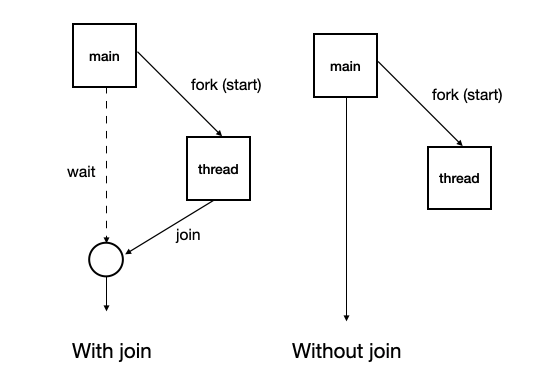

In [ ]:
%%timeit -n 1 -r 1

# Without a join ...

thread1 = MyThread('A', 0.5) 

thread1.start() 

print()
print('**** Finished. ****')
print()

## How to resolve the printing problem
How can we avoid the problem where one thread starts printing a message before another thread has terminated it's printed line (see above)? We can use a lock, to mae sure only one thread is printing at a time!

In [ ]:
%%timeit -n 1 -r 1

lock = threading.Lock()

class MyThread(threading.Thread): 
    def __init__(self, name, delay, log=True):
        threading.Thread.__init__(self) 
        self.name = name
        self.delay = delay
        self.log = log
    
    def run(self):
        lock.acquire()
        print('Starting thread %s.' % self.name) 
        lock.release()
        
        thread_count_down(self.name, self.delay, self.log) 
        
        lock.acquire()
        print('Finished thread %s.' % self.name)
        lock.release()
        
def thread_count_down(name, delay, log): 
    counter = 5
    while counter:
        time.sleep(delay)
        # this sleep simulates the waiting time that could result, for example, from reading data from file,
        # or reading data from some API (e.g., getting webpage), or executing an SQL query on a database server...
        if log:
            lock.acquire()
            print('Thread %s counting down: %i...' % (name, counter)) 
            lock.release()
        counter -= 1
            

thread1 = MyThread('A', 0.5) 
thread2 = MyThread('B', 0.5)
thread3 = MyThread('C', 0.5)
thread4 = MyThread('D', 0.5)

thread1.start() 
thread2.start()
thread3.start()
thread4.start()


thread1.join()
thread2.join()
thread3.join()
thread4.join()

print('Finished.')

In [ ]:
def sum_numbers(filename, delay=0.1):
    result = 0
    with open(filename, "r") as f:
        for r in f:
            time.sleep(delay)
            r = r.strip()
            if r.isdigit():
                result += int(r)
    return result


In [ ]:
%%timeit -n 1 -r 1

# sum all random numbers from the first test file we created in the beginning

i = 0
res = sum_numbers(f"test_files/file_{i}.txt",)
print(i, res)

In [ ]:
%%timeit -n 1 -r 1

# sum all random numbers for each of the first four test files (sequentially)

for i in range(4):
    res = sum_numbers(f"test_files/file_{i}.txt",)
    print(i, res)

In [ ]:
%%timeit -n 1 -r 1

# now comupute the sum of the first file again, this time using a single thread

threads = []
for i in range(1):
    threads.append(Thread(target=sum_numbers, args=(f"test_files/file_{i}.txt",)))

for t in threads:
    t.start()
    
for t in threads:
    t.join()

In [ ]:
%%timeit -n 1 -r 1

# and also compute the sums for the first four files, using four threads

threads = []
for i in range(4):
    threads.append(Thread(target=sum_numbers, args=(f"test_files/file_{i}.txt",)))

for t in threads:
    t.start()
    
for t in threads:
    t.join()

In [ ]:
%%timeit -n 1 -r 1

# now compute the sums for each of the 1000 test files using one thread for each!

threads = []
for i in range(1000):
    threads.append(Thread(target=sum_numbers, args=(f"test_files/file_{i}.txt",)))

for t in threads:
    t.start()
    
for t in threads:
    t.join()

Doing this for 1000 files takes the same time as doing it for one single file! Impressive isn't it?
We can say that ...
### So far "parallelization" seems to work well!
(But you're probably already suspecting that what we have seen is actually not true parallelization but instead we're executing everything on a single core, just nicely exploiting the idle times of the CPU to switch between the individual threads to get them all done concurrently. This works well, in the tasks above, the CPU is idle most of the time, either because we use sleep() or because it has to wait for the single data items to be read from a file; in this case mostly due the delay/sleep time of 0.1, but also reading data from a file plays a role.)

Now let's do some tasks that involve a larger fraction of CPU time and less idle time. We can achieve this by simply having a much shorter delay (sleep) time when summing numbers. The defauly delay we used above was 0.1, now let's take 0.0001 ...

In [ ]:
%%timeit #-n 1 -r 1

# One file takes a few miliseconds (here, timeit runs it multiple times to get some performance statistics, 
# but a single run would take only a few miliseconds ...)

i = 0
sum_numbers(f"test_files/file_{i}.txt", 0.0001)

In [ ]:
%%timeit -n 1 -r 1

# all 1000 files (sequentially) take a few seconds

i = 0
for i in range(1000):
    sum_numbers(f"test_files/file_{i}.txt", 0.0001)

In [ ]:
%%timeit #-n 1 -r 1

# How long will it take if we create 1000 threads, one for each file? A few miliseconds or a few seconds?

threads = []
for i in range(1000):
    threads.append(Thread(target=sum_numbers, args=(f"test_files/file_{i}.txt", 0.0001)))

for t in threads:
    t.start()
    
for t in threads:
    t.join()

In the above cell, multithreading helps us, but not as much as before.

Pausing time is really low (0.0001 seconds) and managing many different tasks when there are no comparably long idle times makes the case worse!!

With delay=0.1, running 1000 threads took the same time as running a single thread (see above), with a delay=0.0001, running 1000 threads takes much longer than running a single thread, because there is less idle time that an be exploited to switch between tasks.

What if we set the delay to **0** (no idle times) and run on all files ... ? Using 1000 threads will take LONGER than processing all 1000 files sequentially!!!! Why? Because additionally to do all the processing without being able to exploit significant CPU idle times, we have significant overload because we constantly need to switch between different tasks (context switching! store the context of task X, the load the context of task Y, run a part of Y, then store the context of Y, then load the previous context of task Z, then run a part of Z, then ... and so on!)

In [ ]:
%%timeit -n 1 -r 1

i = 0
for i in range(1000):
    sum_numbers(f"test_files/file_{i}.txt", 0)

In [ ]:
%%timeit -n 1 -r 1

threads = []
for i in range(1000):
    threads.append(Thread(target=sum_numbers, args=(f"test_files/file_{i}.txt", 0)))

for t in threads:
    t.start()
    
for t in threads:
    t.join()

In [ ]:
# The remainder is uncommented ... try to figure out what is happening!

random.seed(0)
random_numbers = [random.randrange(5_000_000, 10_000_000) for _ in range(4)]
random_numbers

In [ ]:
def sum_range(inp, th_id=None):
    res = 0
    if th_id is not None:
        print("Thread starts", th_id)
    for x in range(inp):
        res += x**2
    if th_id is not None:
        print("Thread is finished", th_id)
    return res

In [ ]:
avg = sum(random_numbers) // len(random_numbers)
avg

In [ ]:
%%timeit -n 1 -r 1
sum_range(avg)

In [ ]:
%%timeit -n 1 -r 1
for x in random_numbers:
    sum_range(x)

In [ ]:
%%timeit -n 1 -r 1

threads = []
for i,x in enumerate(random_numbers):
    t = Thread(target=sum_range, args=(x, i))
    t.start()
    threads.append(t)
    
for t in threads:
    t.join()

In [ ]:
%%timeit -n 1 -r 1
# from multiprocessing import Process 

processes = []
for x in random_numbers:
    p = Process(target=sum_range, args=(x, ))
    p.start()
    processes.append(p)
    
for p in processes:
    p.join()

#### HOW TO RETURN THE RESULTS

In [ ]:
%%timeit -n 1 -r 1

results = [0 for _ in range(len(random_numbers))]

def sum_range_result_array(inp, i):
    res = 0
    for x in range(inp):
        res += x**2
    results[i] = res
    print('each thread result:', results)
    return res

threads = []
for i, x in enumerate(random_numbers):
    t = Thread(target=sum_range_result_array, args=(x, i))
    t.start()
    threads.append(t)
    
for t in threads:
    t.join()
print(results)

### Try the same solution with multiprocessing:

In [ ]:
#%%timeit -n 1 -r 1

results = [0 for _ in range(len(random_numbers))]

def sum_range_result_array(inp, i):
    global results
    res = 0
    for x in range(inp):
        res += x**2
    results[i] = res
    print('each process result:', results)
    return res

processes = []
for i, x in enumerate(random_numbers):
    p = Process(target=sum_range_result_array, args=(x, i))
    p.start()
    processes.append(p)
    
for p in processes:
    p.join()
print(results)

In [ ]:
%%timeit -n 1 -r 1

def sum_range_result_array(inp, i, results):
    res = 0
    for x in range(inp):
        res += x**2
    results[i] = res
    print('each process result:', results[:])
    return res

processes = []
results = multiprocessing.Array('i', 4)



for i, x in enumerate(random_numbers):
    p = Process(target=sum_range_result_array, args=(x, i, results))
    p.start()
    processes.append(p)
    
for p in processes:
    p.join()
print(results[:])

# COULD IT BE NEGATIVE? 
# Try to use float 'f' 

In [ ]:
random.seed(0)
random_numbers = [random.randrange(5000, 10_000) for x in range(1000)]

In [ ]:
avg = sum(random_numbers) // len(random_numbers)
avg

In [ ]:
%%timeit -n 1 -r 1
for x in random_numbers:
    sum_range(x)

In [ ]:
%%timeit -n 1 -r 1
# from multiprocessing import Process 

processes = []
for x in random_numbers:
    p = Process(target=sum_range, args=(x, ))
    p.start()
    processes.append(p)
    
for p in processes:
    p.join()

**Multiple PROCESSES can be WORSE than SEQUENTIAL!!!!**

Let's create a pool of only 4 processes (no overhead of 1000 processes which can anyway not run in parallel if you don't have 1000 processor cores ...) and send the jobs to them!

In [ ]:
def sum_range(inp):
    res = 0
    for x in range(inp):
        res += x**2
    return res

In [ ]:
%%timeit -n 1 -r 1
pool = Pool(processes = 4)

result = pool.map(sum_range, random_numbers)
print(len(result),'ten result:', result[:10])

pool.close()